In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [6]:
obdir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/'

### Choose which sites to train the SVR model on
Can be all available, or a defined list 'site_list' passed, or single station as list e.g. ['CLN']<br>
Use all with an exclude list is another alternative

In [7]:
flist = glob(obdir + 'combined/*.pd')

# This can be a manual site list if desired
site_list = np.unique([f.split('/')[-1].split('_')[0] for f in flist])

# site_list = [s for s in site_list if 'BSNF' in s]
# site_list = ['CLN', 'AGD', 'ALTA']

site_list

array(['AGD', 'ALTA', 'BCC', 'BSNFDC', 'BSNFEX', 'BSNFJE', 'CLN', 'PVC',
       'SLB'], dtype='<U6')

### For each site, choose which files to use
For now, we will only use one set of observations from each site so samples remain independent<br>
We can change this behavior down the road to use all or some intervals<br>
Favor 'short' for the shortest interval available e.g. 6h, 'long' for longest interval e.g. 24h

In [8]:
# favor = 'long' #'long'

flist = []
for site in site_list:
    
    site_files = glob(obdir + 'combined/%s*.pd'%site)
    
#     if len(site_files) > 1:
#         if favor == 'short':
#             flist.append(
#                 site_files[np.argmin([int(f.split('.')[-2].replace('h', '')) 
#                     for f in site_files])])
            
#         elif favor == 'long':
#             np.argmax([int(f.split('.')[-2].replace('h', '')) for f in site_files])
    
#     else:
    flist.append(site_files)#[0])
        
flist = np.hstack(flist)
flist

array(['/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/AGD_2004_2019.24h.pd',
       '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/AGD_2004_2019.12h.pd',
       '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/ALTA_1980_2019.24h.pd',
       '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/BCC_2007_2019.24h.pd',
       '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/BCC_2007_2019.12h.pd',
       '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/BSNFDC_2005_2019.24h.pd',
       '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/BSNFEX_2012_2019.24h.pd',
       '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/BSNFJE_2005_2019.24h.pd',
       '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observati

### Establish which model variables and levels to use
This is entirely based on the model that the SVR will be applied to - maximize the predictor set<br>
Helpful to open a sample GFS/NAM/HRRR grid or profile to derive the variable list from

### Import the compiled data
Prune unused variables on import based on the list above<br>
Sub-surface levels have already been dealt with in the compilation script - modify methods there<br>
Note that 12 vs 24 hour intervals have also been dealt with above, if both desired... write that in

In [9]:
use_var_type = ['mean']#, 'max', 'min']

data = []
for f in flist:
    
    site = f.split('/')[-1].split('_')[0]
    interval = int(f.split('/')[-1].split('.')[-2].replace('h', ''))
    
    df = pd.read_pickle(f)
    
    exclude_keys = ['VO', 'Z', 'W'] #['Z', '2T', 'TSFC', 'CAPE', 'VO', 'W', 'V', 'U']
    exclude_keys = np.array([[k if ex in k[:len(ex)] else np.nan 
                              for ex in exclude_keys] for k in df.keys()])
    exclude_keys = exclude_keys.flatten()
    exclude_keys = exclude_keys[exclude_keys != 'nan']
    
    keys = ['slr', 'swe_mm']

    keys.extend(np.hstack([[k for k in df.keys() if vt in k] for vt in use_var_type]))

    df = df.loc[:, keys].rename(columns={[k for k in keys if 'swe' in k][0]:'swe_mm'})
    df = df.loc[:, :].rename(columns={[k for k in keys if 'swe' in k][0]:'swe_mm'})
    df = df.rename(columns={[k for k in keys if 'slr' in k][0]:'slr'})
    df = df.drop(columns=[k for k in keys if 'auto' in k])
    
    # df.insert(0, 'site', np.full(df.index.size, fill_value=site, dtype='U10'))
    doy = [int(pd.to_datetime(d).strftime('%j')) for d in df.index]
    df.insert(2, 'day_of_year', doy)
    
    data.append(df.reset_index().drop(columns='time'))

data = pd.concat(data, sort=False)

# Treat the mean value as the instantaneous value for later applications,
# we can change this behavior later on if desired. 
# An alternate method would be to keep the 'mean' tag through training 
# and choose behavior upon application
data = data.rename(columns={k:k.replace('_mean', '') for k in data.keys()})

data = data.drop(columns='SP')

print(data.shape)
data.head()

(7646, 106)


,slr,swe_mm,day_of_year,Q_01agl,T_01agl,U_01agl,V_01agl,VO_01agl,W_01agl,Z_01agl,...,CAPE,MSL,U10M,V10M,U100M,V100M,SPD10M,DIR10M,SPD100M,DIR100M
0,5.884170,12.95,314,0.004998,282.703613,-2.412662,1.019774,-0.000117,0.325795,19623.570312,...,16.625,101563.398438,-1.797048,0.601576,-2.510218,1.441005,1.971800,108.770012,3.074048,122.917458
1,5.318258,11.94,329,0.002751,270.745026,0.465854,-0.132118,0.000043,-0.036050,19720.195312,...,0.245,102496.562500,0.190780,0.362110,0.818864,0.244969,1.172219,187.995560,1.427766,243.507050
2,12.211539,21.84,330,0.003472,275.207092,-0.070692,2.942799,-0.000173,0.161854,19575.107422,...,0.785,101940.070312,-0.430602,1.840145,0.024700,3.492149,2.040003,168.747421,3.617625,182.818176
3,12.200001,25.40,331,0.003932,275.856049,0.340978,2.117878,-0.000128,0.056763,19261.904297,...,3.590,101485.796875,0.227602,1.250961,0.800089,2.296890,1.909311,204.083237,3.194682,213.687454
4,16.343679,13.21,332,0.002982,271.394714,0.997408,-1.360267,0.000091,0.004366,19367.664062,...,31.320,101991.617188,0.491865,-0.699195,1.275965,-1.004299,1.864576,234.394958,2.894353,251.885300


### Hard trim data based on criteria

In [10]:
min_slr, max_slr = 2.5, 30
max_T650 = 0 + 273.15
min_swe_mm = 2.54

data = data[data['slr'] >= min_slr]
data = data[data['slr'] <= max_slr]
data = data[data['T_01agl'] <= max_T650]
data = data[data['swe_mm'] >= min_swe_mm]

# data = data[[k for k in data.keys() if 'swe' not in k]]

print(data.shape)

(3437, 106)


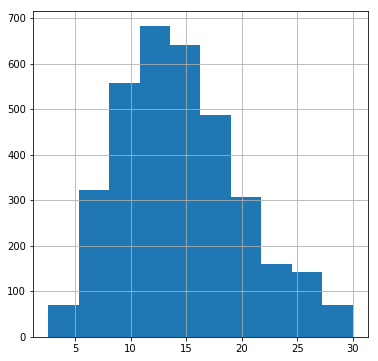

In [11]:
plt.figure(facecolor='w', figsize=(6, 6))
data['slr'].hist()

<hr><hr>

### Investigate basic bulk statistics and linear correlations
Quanitfy how certain variables are related and produce plots to visualize this<br>

#### *Removed: Normalize/Standardize
Moved down to where datasets are split. If need be we can normalize for the plots below here too...

#### Pair Plots

#### Correlation Matrix, R2 Matrix

#### Linear Correlation Verical Plots, R2 Vertical Plots

#### Identify autocorrelated and other dependent predictors
Mask these if desired

<hr><hr>

### Split Train/Test/Validate Sets
If we want to expand the hyperparameter tuning, we can test for sensitivity to random sample<br>
by looping from bottom of code block back to here<br>

In [12]:
# int(slr) for stratification (> 1 ct per class label)
data = data.dropna()
fac = 5
slr = np.round(data['slr']/fac, 0)*fac
slr.value_counts()

10.0    1113
15.0    1091
20.0     629
5.0      282
25.0     260
30.0      62
Name: slr, dtype: int64

In [13]:
print('Total: %d'%len(data))

# Split into train/test sets
train_size, test_size, random_state = None, 0.33, 5
X_train, X_test = train_test_split(data, 
                                       test_size=test_size, train_size=train_size, 
                                       random_state=random_state, stratify=slr)

# Perform a secondary split if separate validation set required

# Split off the target variable now that TTsplit is done
y_train, y_test = X_train.pop('slr'), X_test.pop('slr')
# y_train = np.round(y_train/fac, 0)*fac

print('Train: {}\nTest: {}\nValidate: {}'.format(X_train.shape[0], X_test.shape[0], None))

train_stats = X_train.describe().T
train_stats.head(10)

Total: 3437
Train: 2302
Test: 1135
Validate: None


,count,mean,std,min,25%,50%,75%,max
swe_mm,2302.0,12.939285,10.772969,2.790000,6.100000,9.910000,16.002001,129.029999
day_of_year,2302.0,148.432233,143.753454,1.000000,35.000000,65.000000,336.750000,366.000000
Q_01agl,2302.0,0.002174,0.000899,0.000141,0.001524,0.002129,0.002859,0.004601
T_01agl,2302.0,267.608551,5.017713,242.386627,265.437561,268.880798,271.287148,273.142578
U_01agl,2302.0,3.191966,4.934930,-11.897518,-0.295245,1.411821,6.344662,27.602119
V_01agl,2302.0,-1.038881,5.201777,-29.419476,-2.930889,-0.227902,1.907769,22.588367
VO_01agl,2302.0,-0.000018,0.000116,-0.000467,-0.000050,-0.000004,0.000036,0.000419
W_01agl,2302.0,0.038476,0.233864,-0.832945,-0.081422,0.043579,0.159679,0.778903
Z_01agl,2302.0,20028.275391,2212.772461,16694.800781,18577.897461,19093.364258,20063.340820,25226.091797
R_01agl,2302.0,71.415291,18.665964,7.590972,59.050518,75.272060,86.091547,101.111160


### Normalize/Standardize the data
We are using z-score normalization for now but other methods exist<br>
This is an absolute must for working with any of the ML models available to us<br>
Normalize based on the TRAINING dataset

In [14]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [15]:
scaler = RobustScaler(quantile_range=(25, 75)).fit(X_train)

X_train_norm = pd.DataFrame(scaler.transform(X_train.loc[:, list(X_train.keys())]), columns=X_train.keys())
X_test_norm = pd.DataFrame(scaler.transform(X_test.loc[:, list(X_train.keys())]), columns=X_train.keys())

X_train_norm.describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
swe_mm,2302.0,0.305927,1.087959,-0.719047,-0.384771,0.0,0.615229,12.029892
day_of_year,2302.0,0.276495,0.476399,-0.212096,-0.099420,0.0,0.900580,0.997514
Q_01agl,2302.0,0.033720,0.673512,-1.489785,-0.453054,0.0,0.546946,1.851688
T_01agl,2302.0,-0.217535,0.857790,-4.529238,-0.588629,0.0,0.411371,0.728561
U_01agl,2302.0,0.268098,0.743223,-2.004447,-0.257092,0.0,0.742908,3.944377
V_01agl,2302.0,-0.167604,1.075045,-6.032990,-0.558623,0.0,0.441377,4.715413
VO_01agl,2302.0,-0.158845,1.341348,-5.372866,-0.536832,0.0,0.463168,4.900612
W_01agl,2302.0,-0.021163,0.969984,-3.635502,-0.518459,0.0,0.481541,3.049859
Z_01agl,2302.0,0.629385,1.489638,-1.614712,-0.347012,0.0,0.652988,4.128550
R_01agl,2302.0,-0.142627,0.690283,-2.502904,-0.599886,0.0,0.400114,0.955552


Print out plots describing the variability in the data (+ before/after normalization?)<br>
It would be valuable to do a similar set of/novel comparison plots with the ERA5 vs GFS<br>
for each variable/level in the validation script (separate from and following this script)

### EOF/PCA Reduction of highly dimensional data
There are implementations of atmospheric data in ML models that heavily leverage<br>
EOFs to reduce highly dimensional data to simpler components<br>
Evaluate if this is viable here as it will be applied to raw variables later on

### Use LASSO/Ridge regression to determine predictor rank/impact
L1/L2 Parameter Tuning -- Use to select relevant predictors, reduce irrelevant to zero, rank by influence

In [16]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_norm, y_train)

lr_train_score = lr.score(X_train_norm, y_train)
lr_test_score = lr.score(X_test_norm, y_test)

print('Linear Regression Train Score: %.3f'%lr_train_score)
print('Linear Regression Test Score: %.3f'%lr_test_score)

Linear Regression Train Score: 0.313
Linear Regression Test Score: 0.278


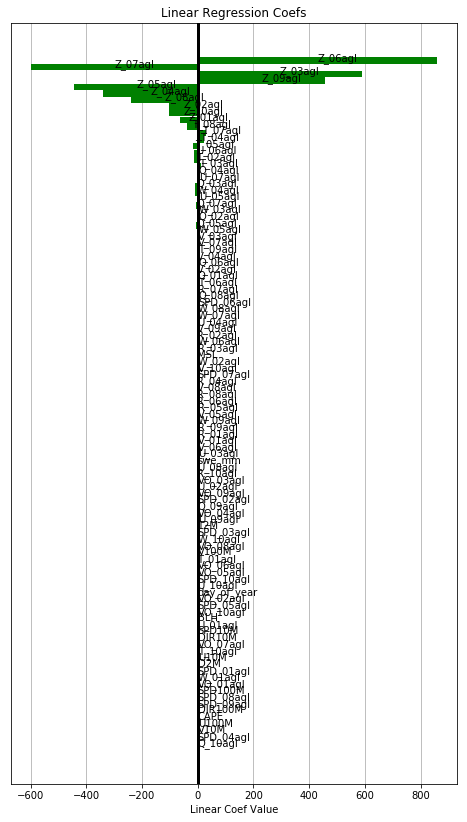

In [17]:
fig, ax = plt.subplots(1, 1, facecolor='w', figsize=(8, 14))

ranksort = np.argsort(abs(lr.coef_))[::-1]
lr_coefs = lr.coef_[ranksort]
lr_keys = X_train_norm.keys()[ranksort]
mask = lr_coefs != 0

ax.axvline(0, color='k', linewidth=3, zorder=11)
ax.barh(lr_keys[mask], lr_coefs[mask], color='green', zorder=10, height=0.97)

for i, k in enumerate(lr_keys[mask]):
    if lr_coefs[i] != 0:
        ax.text(lr_coefs[i]/2, k, k, zorder=20)

ax.invert_yaxis()
ax.axes.get_yaxis().set_visible(False)
ax.set_title('Linear Regression Coefs')
ax.set_xlabel('Linear Coef Value')
ax.grid(zorder=-1)

In [18]:
from sklearn.linear_model import Ridge

# The higher the alpha value, more restriction on the coefficients; 
# low alpha > more generalization, coefficients are barely restricted
rr_alpha_tune = []
for alpha in np.append(np.arange(0.01, 1, 0.01), np.arange(1, 1000, 1)):

    rr = Ridge(alpha=alpha)
    rr.fit(X_train, y_train)

    rr_train_score = rr.score(X_train, y_train)
    rr_test_score = rr.score(X_test, y_test)
    
    rr_alpha_tune.append([alpha, rr_train_score, rr_test_score, rr])
rr_alpha_tune = np.array(rr_alpha_tune)

alpha, rr_train_score, rr_test_score, rr = rr_alpha_tune[np.argmax(rr_alpha_tune[:, 2])]
print('Ridge Regression alpha: %.3f'%alpha)
print('Ridge Regression Train Score: %.3f'%rr_train_score)
print('Ridge Regression Test Score: %.3f'%rr_test_score)

Ridge Regression alpha: 5.000
Ridge Regression Train Score: 0.289
Ridge Regression Test Score: 0.279


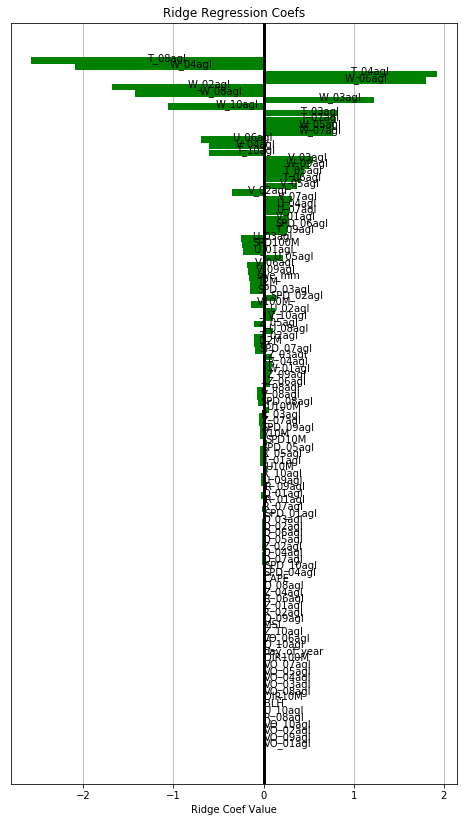

In [19]:
fig, ax = plt.subplots(1, 1, facecolor='w', figsize=(8, 14))

ranksort = np.argsort(abs(rr.coef_))[::-1]
rr_coefs = rr.coef_[ranksort]
rr_keys = X_train_norm.keys()[ranksort]
mask = rr_coefs != 0

ax.axvline(0, color='k', linewidth=3, zorder=11)
ax.barh(rr_keys[mask], rr_coefs[mask], color='green', zorder=10, height=0.97)

for i, k in enumerate(rr_keys[mask]):
    if rr_coefs[i] != 0:
        ax.text(rr_coefs[i]/2, k, k, zorder=20)

ax.invert_yaxis()
ax.axes.get_yaxis().set_visible(False)
ax.set_title('Ridge Regression Coefs')
ax.set_xlabel('Ridge Coef Value')
ax.grid(zorder=-1)

In [20]:
from sklearn.linear_model import Lasso

lasso_alpha_tune = []
for alpha in np.arange(0.001, .01, 0.001):

    lasso = Lasso(alpha=alpha, max_iter=10e5)
    lasso.fit(X_train_norm, y_train)

    lasso_train_score = lasso.score(X_train_norm, y_train)
    lasso_test_score = lasso.score(X_test_norm, y_test)
    lasso_coeff_used = np.sum(lasso.coef_ != 0)
    
    lasso_alpha_tune.append([alpha, lasso_train_score, lasso_test_score, lasso])
lasso_alpha_tune = np.array(lasso_alpha_tune)

alpha, lasso_train_score, lasso_test_score, lasso = lasso_alpha_tune[np.argmax(lasso_alpha_tune[:, 2])]
print('Lasso alpha: %.3f'%alpha)
print('Lasso Train Score: %.3f'%lasso_train_score)
print('Lasso Test Score: %.3f'%lasso_test_score)
print('Number of Features Used: %d'%lasso_coeff_used)

Lasso alpha: 0.009
Lasso Train Score: 0.286
Lasso Test Score: 0.283
Number of Features Used: 57


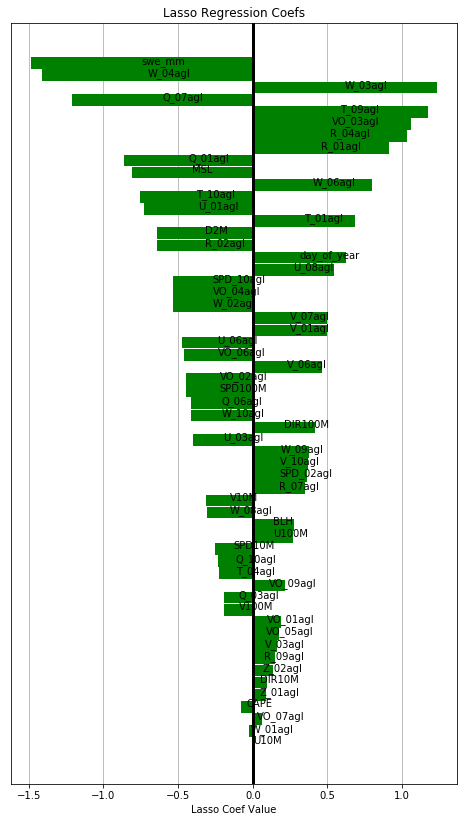

In [21]:
fig, ax = plt.subplots(1, 1, facecolor='w', figsize=(8, 14))

ranksort = np.argsort(abs(lasso.coef_))[::-1]
lasso_coefs = lasso.coef_[ranksort]
lasso_keys = X_train_norm.keys()[ranksort]
mask = lasso_coefs != 0

ax.axvline(0, color='k', linewidth=3, zorder=11)
ax.barh(lasso_keys[mask], lasso_coefs[mask], color='green', zorder=10, height=0.97)

for i, k in enumerate(lasso_keys[mask]):
    if lasso_coefs[i] != 0:
        ax.text(lasso_coefs[i]/2, k, k, zorder=20)

ax.invert_yaxis()
ax.axes.get_yaxis().set_visible(False)
ax.set_title('Lasso Regression Coefs')
ax.set_xlabel('Lasso Coef Value')
ax.grid(zorder=-1)

plt.show()

In [22]:
from sklearn.linear_model import ElasticNet

# Grid-search for best parameters? (alpha and l1_ratio)

elastic = ElasticNet(alpha=0.009, l1_ratio=0.1, max_iter=10e5)
elastic.fit(X_train_norm, y_train)

elastic_train_score = elastic.score(X_train_norm, y_train)
elastic_test_score = elastic.score(X_test_norm, y_test)
elastic_coeff_used = np.sum(elastic.coef_ != 0)
    
print('Elastic Train Score: %.3f'%elastic_train_score)
print('Elastic Test Score: %.3f'%elastic_test_score)

Elastic Train Score: 0.289
Elastic Test Score: 0.285


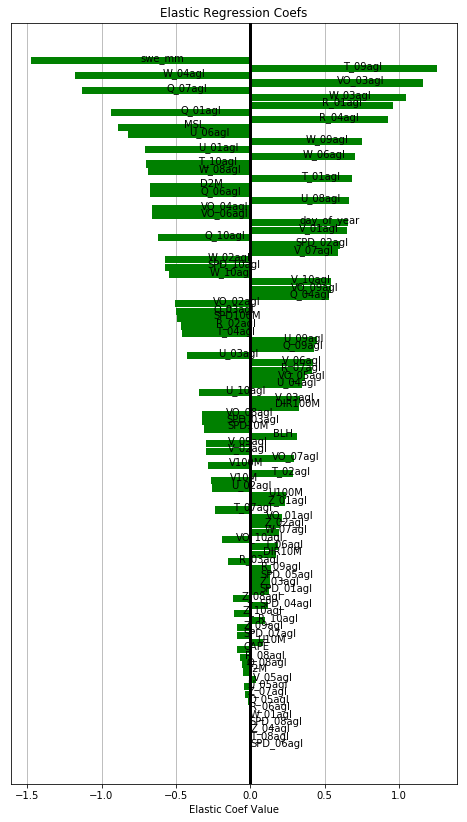

In [23]:
fig, ax = plt.subplots(1, 1, facecolor='w', figsize=(8, 14))

ranksort = np.argsort(abs(elastic.coef_))[::-1]
elastic_coefs = elastic.coef_[ranksort]
elastic_keys = X_train_norm.keys()[ranksort]
mask = elastic_coefs != 0

ax.axvline(0, color='k', linewidth=3, zorder=11)
ax.barh(elastic_keys[mask], elastic_coefs[mask], color='green', zorder=10, height=0.97)

for i, k in enumerate(elastic_keys[mask]):
    if elastic_coefs[i] != 0:
        ax.text(elastic_coefs[i]/2, k, k, zorder=20)

ax.invert_yaxis()
ax.axes.get_yaxis().set_visible(False)
ax.set_title('Elastic Regression Coefs')
ax.set_xlabel('Elastic Coef Value')
ax.grid(zorder=-1)

plt.show()

#### If we want to use feature selection, we can do so here.
Can choose the model from which to take features, do so manually, or not at all (set equal to X_train.keys())

Top Predictor: swe_mm


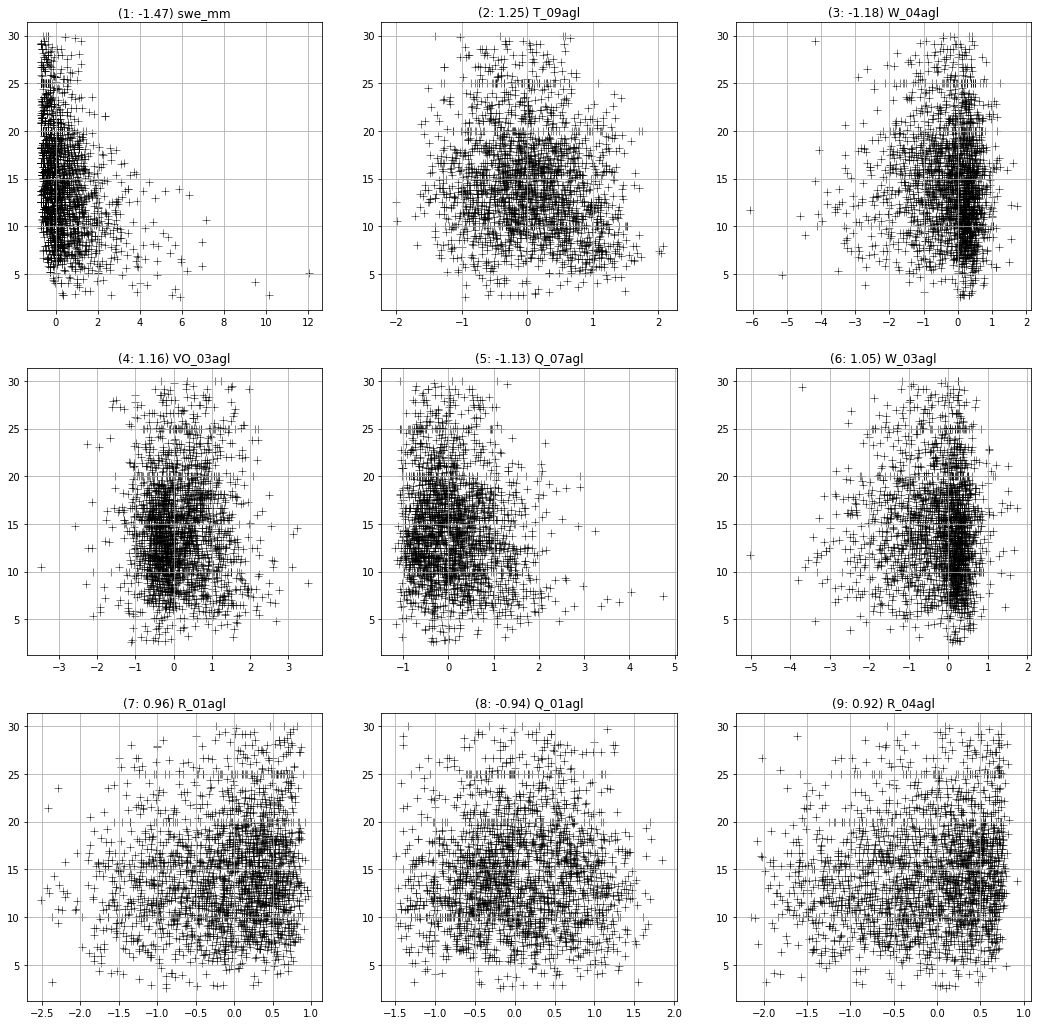

In [24]:
print('Top Predictor: %s'%elastic_keys[0])
fig, axs = plt.subplots(3, 3, figsize=(18, 18), facecolor='w')
axs = axs.flatten()

for i, ax in enumerate(axs):
    ik, ic = elastic_keys[i], elastic_coefs[i]
    ax.scatter(X_train_norm[ik], y_train, c='k', marker='+', s=65, linewidth=0.5)
    ax.set_title('(%d: %.2f) %s'%(i+1, ic, ik))
    ax.grid()

plt.show()

In [25]:
drop_low_import = False

if drop_low_import:
    feature_selection = elastic_keys[mask]
    feature_selection

    pre_select = X_train_norm.keys()
    X_train_norm = X_train_norm[feature_selection]
    X_test_norm = X_test_norm[feature_selection]
    post_select = X_train_norm.keys()

    print('dropped:', [k for k in pre_select if k not in post_select])

    print(X_train_norm.shape)
    print(X_test_norm.shape)

In [26]:
from sklearn.neural_network import MLPRegressor

for layer_sizes in [500]:
    mlp = MLPRegressor(
        hidden_layer_sizes=(layer_sizes,), 
        activation='relu', 
        solver='sgd', 
        alpha=0.00001, 
        batch_size='auto', 
        learning_rate='adaptive', 
        learning_rate_init=0.01, 
        power_t=0.5, 
        max_iter=50000, 
        shuffle=True, 
        random_state=random_state, 
        tol=0.0001, 
        verbose=False, 
        warm_start=False, 
        momentum=0.7, 
        nesterovs_momentum=True, 
        early_stopping=False, 
        validation_fraction=0.3, 
        beta_1=0.5, 
        beta_2=0.999, 
        epsilon=1e-8)

    mlp.fit(X_train_norm, y_train)

    mlp_train_score = mlp.score(X_train_norm, y_train)
    mlp_test_score = mlp.score(X_test_norm, y_test)
    
    # mlp_coeff_used = np.sum(mlp.coef_ != 0)

    print('Layer Sizes: %d'%layer_sizes)
    print('MLP Train Score: %.3f'%mlp_train_score)
    print('MLP Test Score: %.3f'%mlp_test_score)
    print()

Layer Sizes: 500
MLP Train Score: 0.771
MLP Test Score: 0.411



Text(0.5,0.98,'MultiLayer Perceptron (Simple ANN) [500 Hidden Layer Sizes]')

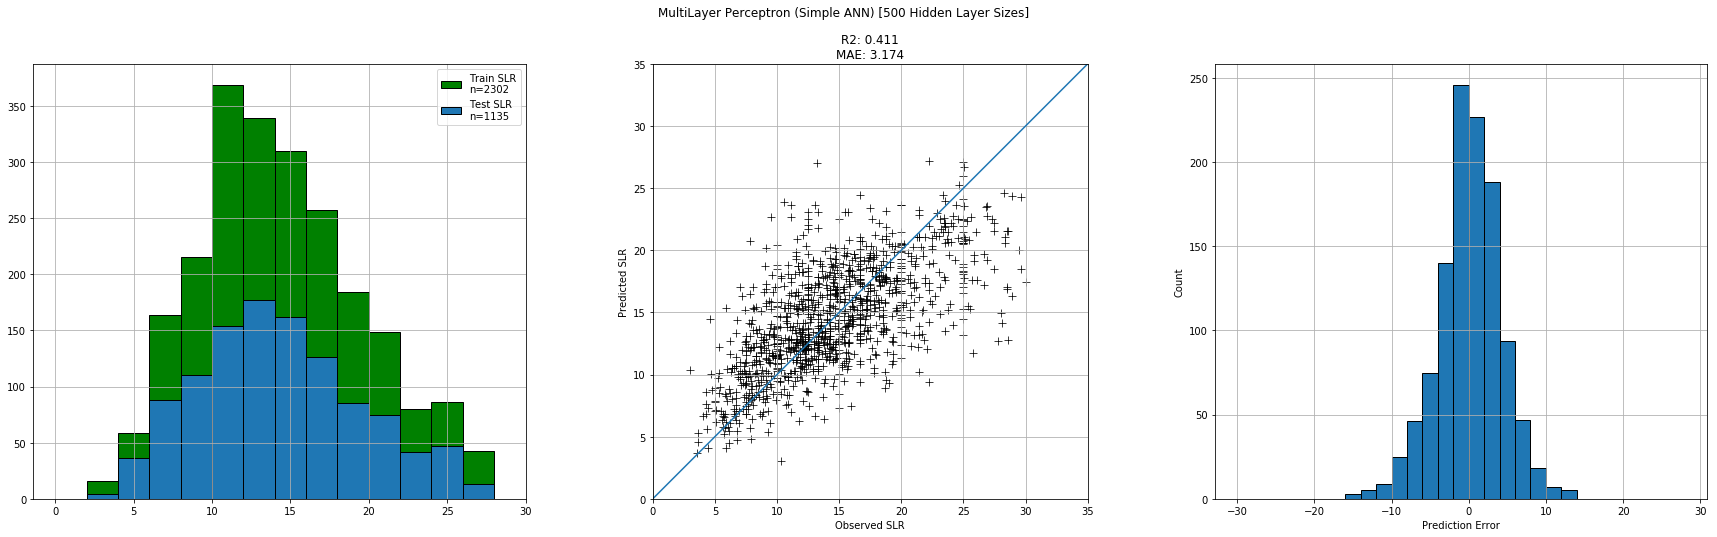

In [27]:
test_predictions = mlp.predict(X_test_norm)
mlp_mae = np.nanmean(abs(test_predictions - y_test))

maxslr = test_predictions.max() if test_predictions.max() > y_test.max() else y_test.max()
maxslr += 5

fig, axs = plt.subplots(1, 3, figsize=(30, 8), facecolor='w')

ax = axs[0]
maxslr = y_test.max() if y_test.max() > y_train.max() else y_train.max()

ax.hist(y_train, bins=np.arange(0, maxslr, 2), color='g', edgecolor='k', alpha=1.0, label='Train SLR\nn=%d'%len(y_train))
ax.hist(y_test, bins=np.arange(0, maxslr, 2), color='C0', edgecolor='k', alpha=1.0, label='Test SLR\nn=%d'%len(y_test))
ax.legend()

ax.set_xticks(np.arange(0, maxslr+1, 5))
ax.set_xticklabels(np.arange(0, maxslr+1, 5).astype(int))
ax.grid()

ax = axs[1]
maxslr = test_predictions.max() if test_predictions.max() > y_test.max() else y_test.max()
maxslr += 5
ax.scatter(y_test, test_predictions, c='k', s=50, marker='+', linewidth=0.75)
ax.set_xlabel('Observed SLR')
ax.set_ylabel('Predicted SLR')
ax.plot([0, maxslr], [0, maxslr])
ax.set_xlim([0, maxslr])
ax.set_ylim([0, maxslr])
ax.set_aspect('equal')
ax.grid()
axs[1].set_title('R2: %.3f\nMAE: %.3f'%(mlp_test_score, mlp_mae))

ax = axs[2]
error = test_predictions - y_test
ax.hist(error, bins=np.arange(-30, 30, 2), edgecolor='k')
ax.set_xlabel('Prediction Error')
ax.set_ylabel('Count')
ax.grid()

fig.suptitle('MultiLayer Perceptron (Simple ANN) [%d Hidden Layer Sizes]'%layer_sizes)

<hr><hr>

### Implement Support Vector Regression Model
(Other ML models like ANN from keras, tensorflow, pytorch may be used in this block)

Implement a K-Fold Cross Validation to assess model performance (Optional, recommended)

Make the SVR model multiprocess friendly

In [35]:
def MARE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

def SVR_mp(_params):
    
    print('.', end='')
    
    _i, _j, _C, _e = _params
    
    _model = SVR(
                C=_C, #Ridge regularization parameter for (L2)^2 penalty
                epsilon=_e, #Specifies the epsilon-tube within which no penalty is associated in the training loss function
                kernel='rbf', #'linear', 'polynomial', 'rbf'
                degree=3, #pass interger for 'polynomial' kernel, ignored otherwise
                tol=0.001, #stopping tolerance
                shrinking=False, 
                cache_size=200, 
                verbose=False)
    
    _model.fit(X_train_norm, y_train)
    
    test_predictions = _model.predict(X_test_norm).flatten()
    _r2 = _model.score(X_test_norm, y_test) #sklearn.metrics.r2_score(y_test.values.flatten(), test_predictions)
    _mse = sklearn.metrics.mean_squared_error(y_test.values.flatten(), test_predictions)
    _mae = sklearn.metrics.mean_absolute_error(y_test.values.flatten(), test_predictions)
    _mare = MARE(y_true, y_pred)
    
    return (_i, _j, _C, _e, _r2, _mae, _mse, _mare, _model)

In [36]:
import multiprocessing as mp
from sklearn.svm import SVR
import sklearn

# Best test
crange = np.arange(1, 60, 1)
erange = np.arange(0.0, 5.1, .1)

# crange = np.arange(1, 25, 1)
# erange = np.arange(0.1, 3.1, .1)

params = {}
params['r2'] = np.zeros((len(crange), len(erange)))
params['mae'] = np.zeros((len(crange), len(erange)))
params['mse'] = np.zeros((len(crange), len(erange)))
params['mare'] = np.zeros((len(crange), len(erange)))
params['model'] = np.empty((len(crange), len(erange)), dtype='object')
params['epsilon'] = np.zeros((len(crange), len(erange)))
params['C'] = np.zeros((len(crange), len(erange)))

mp_params = np.array([[(i, j, C, e) for j, e in enumerate(erange)] 
                      for i, C in enumerate(crange)]).reshape(-1, 4)

print('Iterations to attempt: %d'%len(mp_params))

Iterations to attempt: 3009


Run SVR, collect output iterated over hyperparameters (C, epsilon)<br>
Specify the cost function/loss function used, tolerances, kernel, error metric, etc

In [37]:
# Paralellize here
# mp_returns = [SVR_mp(_param) for _param in mp_params[:10]]

with mp.get_context('fork').Pool(64) as p:
    mp_returns = p.map(SVR_mp, mp_params, chunksize=1)
    p.close()
    p.join()

for item in mp_returns:
    
    i, j, C, e, r2, mae, mse, mare, model = item
    i, j = int(i), int(j)
        
    params['r2'][i, j] = r2
    params['mse'][i, j] = mse
    params['mae'][i, j] = mae
    params['mare'][i, j] = mare
    params['model'][i, j] = model
    params['epsilon'][i, j] = e
    params['C'][i, j] = C

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Plot model performance over time, cost/loss function evolution and skill

Plot SVR output with hyperparameters (C, epsilon)<br>
Apply a grid-search method to select best performing parameters

MARE  0.24314375693019807


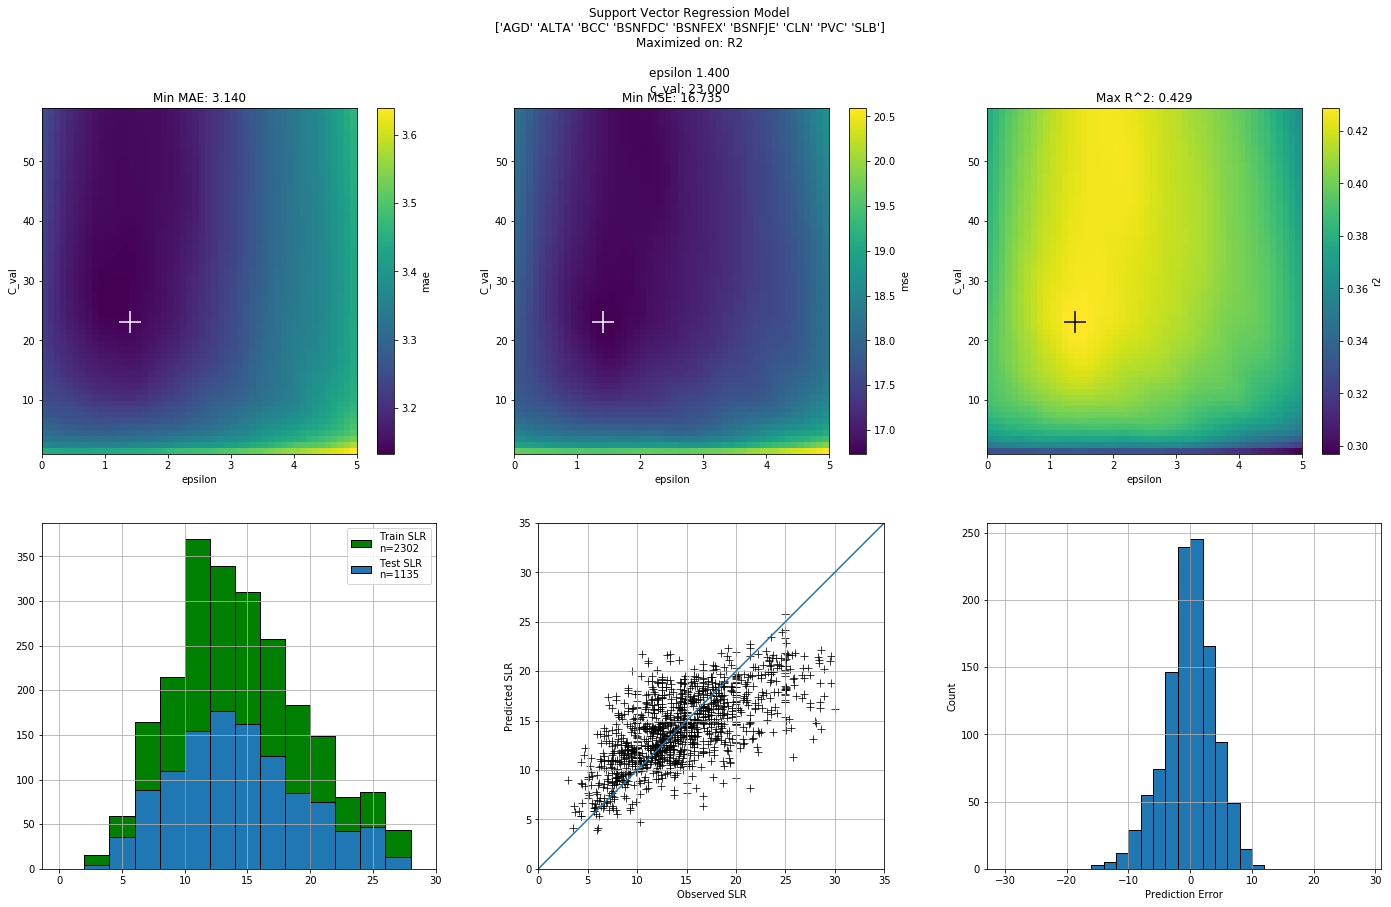

In [41]:
min_on, indexer, _ = 'R2', np.where(params['r2'] == params['r2'].max()), params['r2'].max()
min_on, indexer, _ = 'MAE', np.where(params['mae'] == params['mae'].min()), params['mae'].min()
min_on, indexer, _ = 'MSE', np.where(params['mse'] == params['mse'].min()), params['mse'].min()
min_on, indexer, _ = 'MARE', np.where(params['mare'] == params['mare'].min()), params['mare'].min()

for min_on in ['r2']:
    
    if min_on in ['mse', 'mae', 'mare']:
        min_max = 'Minimized'
        indexer = np.where(params[min_on] == params[min_on].min())
    elif min_on in ['r2']:
        min_max = 'Maximized'
        indexer = np.where(params[min_on] == params[min_on].max())

    r, c = indexer
    r, c = r[0], c[0]
    r, c, _

    model = params['model'][r, c]
    test_predictions = model.predict(X_test_norm)
    
    y_true = y_test
    y_pred = test_predictions
    print('MARE ', MARE(y_true, y_pred))

    fig, axs = plt.subplots(2, 3, facecolor='w', figsize=(24, 14))
    axs = axs.flatten()

    ax = axs[0]
    cbar = ax.pcolormesh(erange, crange, params['mae'])
    plt.colorbar(cbar, label='mae', ax=ax)
    ax.set_title('Min MAE: %.3f'%params['mae'][r, c])
    ax.scatter(params['epsilon'][r, c], params['C'][r, c], s=500, c='w', marker='+')

    ax = axs[1]
    cbar = ax.pcolormesh(erange, crange, params['mse'])
    plt.colorbar(cbar, label='mse', ax=ax)
    ax.set_title('Min MSE: %.3f'%params['mse'][r, c])
    ax.scatter(params['epsilon'][r, c], params['C'][r, c], s=500, c='w', marker='+')

    ax = axs[2]
    cbar = ax.pcolormesh(erange, crange, params['r2'])
    plt.colorbar(cbar, label='r2', ax=ax)
    ax.set_title('Max R^2: %.3f'%params['r2'][r, c])
    ax.scatter(params['epsilon'][r, c], params['C'][r, c], s=500, c='k', marker='+')

    for ax in axs[:3]:
        ax.set_xlabel('epsilon')
        ax.set_ylabel('C_val')
        ax.set_ylim([crange.min(), crange.max()])
        ax.set_xlim([erange.min(), erange.max()])

    ax = axs[3]
    maxslr = y_test.max() if y_test.max() > y_train.max() else y_train.max()

    ax.hist(y_train, bins=np.arange(0, maxslr, 2), color='g', edgecolor='k', alpha=1.0, label='Train SLR\nn=%d'%len(y_train))
    ax.hist(y_test, bins=np.arange(0, maxslr, 2), color='C0', edgecolor='k', alpha=1.0, label='Test SLR\nn=%d'%len(y_test))
    ax.legend()

    ax.set_xticks(np.arange(0, maxslr+1, 5))
    ax.set_xticklabels(np.arange(0, maxslr+1, 5).astype(int))
    ax.grid()

    ax = axs[4]
    maxslr = test_predictions.max() if test_predictions.max() > y_test.max() else y_test.max()
    maxslr += 5
    ax.scatter(y_test, test_predictions, c='k', s=50, marker='+', linewidth=0.75)
    ax.set_xlabel('Observed SLR')
    ax.set_ylabel('Predicted SLR')
    ax.plot([0, maxslr], [0, maxslr])
    ax.set_xlim([0, maxslr])
    ax.set_ylim([0, maxslr])
    ax.set_aspect('equal')
    ax.grid()

    ax = axs[5]
    error = test_predictions - y_test
    ax.hist(error, bins=np.arange(-30, 30, 2), edgecolor='k')
    ax.set_xlabel('Prediction Error')
    ax.set_ylabel('Count')
    ax.grid()

    plt.suptitle('Support Vector Regression Model\n%s\n%s on: %s\n\nepsilon %.3f\nc_val: %.3f'%(site_list, min_max, min_on.upper(), params['epsilon'][r, c], params['C'][r, c]))
    plt.show()

### Describe final trained SVR model
Descriptive plots of predictor coefficient rank/influence<br>
Print out model parameters, error metrics, skill scores

In [42]:
# ranksort = np.argsort(abs(model.coef_))[::-1]
# svr_coefs = model.coef_[0][ranksort][0]
# svr_keys = X_train_norm.keys()[ranksort][0]
# mask = svr_coefs != 0

# fig, ax = plt.subplots(1, 1, facecolor='w', figsize=(8, 14))

# ax.axvline(0, color='k', linewidth=3, zorder=11)
# ax.barh(svr_keys[mask], svr_coefs[mask], color='green', zorder=10, height=0.97)

# for i, k in enumerate(svr_keys):
#     if svr_coefs[i] != 0:
#         ax.text(svr_coefs[i]/2, k, k, zorder=20)

# # ax.invert_yaxis()
# ax.axes.get_yaxis().set_visible(False)
# ax.set_title('SVR Coefs')
# ax.set_xlabel('SVR Coef Value')
# ax.grid(zorder=-1)

# plt.show()

### Save out a usable model along with the input parameters for application
Save with a descriptive filename and a metadata text file!<br>
This will make swapping out models for evaluation much simpler